(EKF)=
## Extended Kalman Filter

In [1]:
# %load imports.py
%load_ext autoreload
%autoreload 2
%reload_kedro
%config Completer.use_jedi = False  ## (To fix autocomplete)
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from src.visualization.plot import track_plots, plot, captive_plot
import kedro
import numpy as np
import os.path
import anyconfig

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('paper')
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"]})

from myst_nb import glue
from src.symbols import *
import src.symbols as symbols
from src.system_equations import *

from IPython.display import display, Math, Latex, Markdown
from sympy.physics.vector.printing import vpprint, vlatex

from src.parameters import df_parameters
p = df_parameters["symbol"]

# Read configs:
conf_path = os.path.join("../../conf/base/")
runs_globals_path = os.path.join(
    conf_path,
    "runs_globals.yml",
)

runs_globals = anyconfig.load(runs_globals_path)
model_test_ids = runs_globals["model_test_ids"]

join_globals_path = os.path.join(
    conf_path,
    "join_globals.yml",
)

joins = runs_globals["joins"]
join_runs_dict = anyconfig.load(join_globals_path)

globals_path = os.path.join(
    conf_path,
    "globals.yml",
)
global_variables = anyconfig.load(globals_path)



vmms = global_variables["vmms"]

2022-05-09 18:16:48,801 - kedro.framework.session.store - INFO - `read()` not implemented for `SQLiteStore`. Assuming empty store.
2022-05-09 18:16:54,441 - root - INFO - ** Kedro project wPCC_pipeline
2022-05-09 18:16:54,443 - root - INFO - Defined global variable `context`, `session`, `catalog` and `pipelines`
2022-05-09 18:16:54,452 - root - INFO - Registered line magic `run_viz`


In [8]:
from wPCC_pipeline.pipelines.preprocess.nodes import filter, assemble_data, add_thrust
from wPCC_pipeline.pipelines.extended_kalman.nodes import create_extended_kalman
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import extended_kalman_filter,extended_kalman_smoother
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, extended_kalman_filter, initial_state, extended_kalman_smoother

It has been shown that it is possible to do parameter identification on perfect (simulated) data with no noise. Such data from physical experiments does not exist in reality however. The measured data will always contain process noise and measurement noise. In order to mitigate this the data is preprocessed using an Extended Kalman filter (EKF). EKF is extending the Kalman Filter (KF) to work on nonlinear systems such as as the VMM:s.

The nonlinear system (the ship) is expressed with a transition model $f(x,u)$ and process noise $w$. $x$ is the current state and $u$ are control inputs (rudder angle and thrust). A VMM is used as the transition model for the model test data EKF.

```{math}
:label: eqnonlinearsystem
\dot{x} = f(x,u) + w
```
The state of the system is observed (measured) with the linear observation model $H$ and measurement noise $v$. 

```{math}
:label: eqobserve
y = Hx + v
```
The used EKF recursive algorithm used is summarized in pseudocode below.



$$\dot{x} = f(x,u) + w $$
$$y = Hx + v $$

```{prf:algorithm} Discrete-time extended Kalman filter
:label: ek-algorithm

**Inputs** Initial values: $x_0$, $P_0$, $C_d$, $R_d$, $Q_d$, $E_d$  

**Output** Estimated states: $\hat{x}$, estimated state covariances $\hat{P}$

1. Initial values:
    1. $\hat{x}[0] = x_0$ 
    2. $\hat{P}[0] = P_0$

2. For $k$ in $n$ measurements

    1. KF gain
        1. $K[k]=\hat{P}[k] C_d^T \left(C_d \hat{P}[k] C_d^T + R_d\right)^{-1}$
        2. $I_{KC} = I_n - K[k] C_d$
        
    2. Update
        1. State corrector
            $\hat{x}[k] = \hat{x}[k] + K[k] (y - C_d \hat{x}[k]) $ 
        2. Covariance corrector
            $\hat{P}[k] = I_{KC} \cdot \hat{P}[k] I_{KC}^T + K[k] R_d K^T $
            
    3. Predict
        1. State predictor
            $\hat{x}[k+1] = \hat{x}[k] + h \cdot \hat{f}(\hat{x}[k], u[k])$
        2. Covariance predictor
            $\hat{P}[k+1] = A_d[k]  \hat{P}[k] A_d[k]^T + E_d Q_d E_d^T $
            

	
```

Where $n$ is number of states (6 in this case), $I_n$ is an $n$ * $n$ identity matrix.

The transition matrix is calculated for each iteration using a Jacobian of the transition model:
```{math}
:label: eqjacobi
A_d[k] = I + h \left. \frac{\partial f \left(x[k],u[k] \right)}{\partial x[k]} \right|_{x[k]=\hat{x}[k]}
```

This part and the fact that the nonlinear transition model is used directly as the predictor are the extensions part of the EKF compared to the linear KF.


$$ A_d[k] = I + h \left. \frac{\partial f \left(x[k],u[k] \right)}{\partial x[k]} \right|_{x[k]=\hat{x}[k]} $$

The output from the filter are the estimated states: $\hat{x}$ and estimated state covariance matrix $\hat{P}$. $\hat{x}$ represent the most likely estimates, but the estimates have uncertainty that are expressed in $\hat{P}$.

The state of the system is descrived by the ships position, heading, velocities and yaw velocity: 

```{math}
:label: eqstates
x = [x_0,y_0,\psi,u,v,r]^T
```

The initial state $x_0$ is taken as the mean value of the first five measurements, where the velocities are estimated with numeric differentiation.  




$$ x = [x_0,y_0,\psi,u,v,r]^T $$

$C_d$ selects the measured states ($x_0$, $y_0$, $\psi$): 
```{glue:math} eqcd
:label: eqcd
```

In [9]:
Cd = sp.symbols('C_d')
eq_Cd = sp.Eq(Cd, h*sp.UnevaluatedExpr(sp.Matrix(
        [
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0],
        ]
    )))

glue('eqcd',eq_Cd)

Eq(C_d, h*Matrix([
[1, 0, 0, 0, 0, 0],
[0, 1, 0, 0, 0, 0],
[0, 0, 1, 0, 0, 0]]))

$E_d$ selects the hidden states ($u$, $v, $r$): 

```{glue:math} eqed
:label: eqed
```
Where $h$ is the discrete time step.

In [10]:
Ed = sp.symbols('E_d')
eq_Ed = sp.Eq(Ed, h*sp.UnevaluatedExpr(sp.Matrix(
        [
            [0, 0, 0],
            [0, 0, 0],
            [0, 0, 0],
            [1, 0, 0],
            [0, 1, 0],
            [0, 0, 1],
        ],
    )))

glue('eqed',eq_Ed)

Eq(E_d, h*Matrix([
[0, 0, 0],
[0, 0, 0],
[0, 0, 0],
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]]))

$R_d$ describes the covariance matrix of the measurement, $Q_d$ is the covariance matrix of the process model. $P_0$ is the initial state covariance.
Selecting good values for these three matrixes is the tricky part in getting the EKF to work well. The amount of expected measurement noise in the data should be inserted in to $R_d$ and the amount of error generated by the process model (VMM) needs to be estimated in $Q_d$. So the choices for these matrixes very much depend on the beleif in the present data and the present process model.

In [11]:
ship='wpcc'
id = "22773"
vmm = "vmm_martins_simple"
data = catalog.load(f"{ship}.{id}.data")
ek = catalog.load(f"{ ship }.{ vmm }.ek")
ek_covariance_input = catalog.load(f"params:{ship}.updated.ek_covariance_input")
model = catalog.load(f"{ship}.updated.{vmm}.joined.model")

2022-05-09 18:17:24,572 - kedro.io.data_catalog - INFO - Loading data from `wpcc.22773.data` (CSVDataSet)...
2022-05-09 18:17:24,645 - kedro.io.data_catalog - INFO - Loading data from `wpcc.vmm_martins_simple.ek` (ExtendedKalmanDataSet)...
2022-05-09 18:17:24,651 - kedro.io.data_catalog - INFO - Loading data from `params:wpcc.updated.ek_covariance_input` (MemoryDataSet)...
2022-05-09 18:17:24,652 - kedro.io.data_catalog - INFO - Loading data from `wpcc.updated.vmm_martins_simple.joined.model` (PickleDataSet)...


In [12]:
ek_covariance_input

{'process_variance': {'u': 0.003, 'v': 0.003, 'r': 0.0019},
 'measurement_error_max': {'positions': 0.05, 'psi': 0.5}}

In [13]:
x0 = initial_state(data=data)
covariance_matrixes = guess_covariance_matrixes(ek_covariance_input=ek_covariance_input, data=data)

In [14]:
data2 = data.copy()
data2.iloc[0].update(x0)
result = model.simulate(data2)
df_sim = result.result

In [15]:
data_noise = df_sim.copy()
data_noise.drop(columns=['u','v','r','u1d','v1d','r1d'], inplace=True)
np.random.seed(42)
data_noise['x0_epsilon']=np.random.normal(0, scale=20*ek_covariance_input['measurement_error_max']['positions']/3, size=len(data_noise))
data_noise['y0_epsilon']=np.random.normal(0, scale=20*ek_covariance_input['measurement_error_max']['positions']/3, size=len(data_noise))
data_noise['psi_epsilon']=np.random.normal(0, scale=20*np.deg2rad(ek_covariance_input['measurement_error_max']['psi']/3), size=len(data_noise))
data_noise['x0']+=data_noise['x0_epsilon']
data_noise['y0']+=data_noise['y0_epsilon']
data_noise['psi']+=data_noise['psi_epsilon']



In [16]:

ek_filtered, data_ek_filter, time_steps = extended_kalman_filter(ek=ek, data=data_noise, covariance_matrixes=covariance_matrixes, x0=x0, hydrodynamic_derivatives=model.parameters, input_columns=['delta', 'thrust'])

(RTS)=
### RTS smoother
EKF only uses the previous time step to make a prediction. This property is very convenient when used in online applications, where new data arrives contineously, for instance in an auto pilot. The drawback is however that the filter is not allowed to look at future time steps. For the PIT on already existing data, this is an uneccessary restriction. An EKF filter can be allowed to include future time steps in the filtering by adding a smoother after the filter. The PIT uses a RTS smoother <cite id="x4n2g"><a href="#zotero|7505983/B44T6S4X">(Rauch et al., 1965)</a></cite> which is an algorithm that runs the EKF backwards to also acount for future time steps. 

In [17]:
ek_smooth, data_ek_smooth = extended_kalman_smoother(ek=ek_filtered, data=data_noise, time_steps=time_steps, covariance_matrixes=covariance_matrixes, hydrodynamic_derivatives=model.parameters)

The EKF and RTS have been run on simulated data with Gausian noise added, to see if the real states can be identified. Results from this can be seen in  [fig](fig_ekf). It can be seen that the EKF can identify the heading and yaw rate well, but the yaw acceleration, being the higher order state is still noisy. The RTS smoother is needed to also get an accurate estimate of the yaw acceleration. 

```{glue:figure} fig_ekf
:figwidth: 1000px
:name: "fig_ekf"

EKF and RTS on simulated data (real) with Gausian noise added (raw).
```

2022-05-09 18:17:42,102 - matplotlib.font_manager - WARNING - findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
2022-05-09 18:17:42,104 - matplotlib.font_manager - WARNING - findfont: Generic family 'serif' not found because none of the following families were found: Times


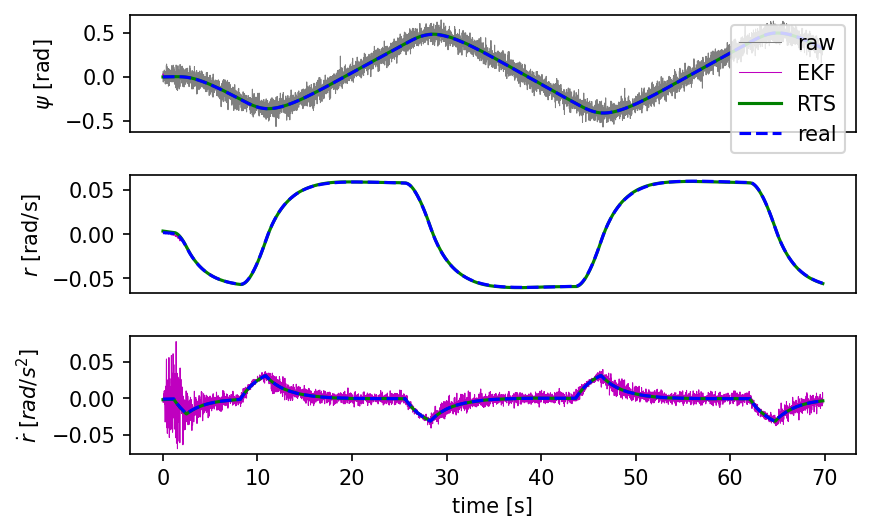

In [18]:
dataframes = {'raw':data_noise,
              'EKF':data_ek_filter,
              'RTS':data_ek_smooth,
              'real':df_sim, 
             }

styles = {
    'raw': {'style':'gray','lw':0.5},
    'real' : {'style':'b--', 'lw':1.5},
    'EKF' : {'style':'m-','alpha':1.0, 'lw':0.5},
    'RTS' : {'style':'g-','alpha':1.0, 'lw':1.5},

}

fig = plot(dataframes, keys=['psi','r','r1d'], styles=styles, ncols=1)
ax = fig.axes[0]
ax.set_xticks([])
ax.set_ylabel(r'$\psi$ [rad]')
ax = fig.axes[1]
ax.set_ylabel(r'$r$ [rad/s]')
ax.set_xticks([])
ax = fig.axes[2]
ax.set_xlabel('time [s]')
ax.set_ylabel(r'$\dot{r}$ $[rad/s^2]$')

plt.tight_layout()

glue('fig_ekf',fig, display=False)

In [19]:
df_variance = pd.DataFrame(ek_filtered.variance.T, index= ek_filtered.time, columns=['x0','y0','psi','u','v','r'])

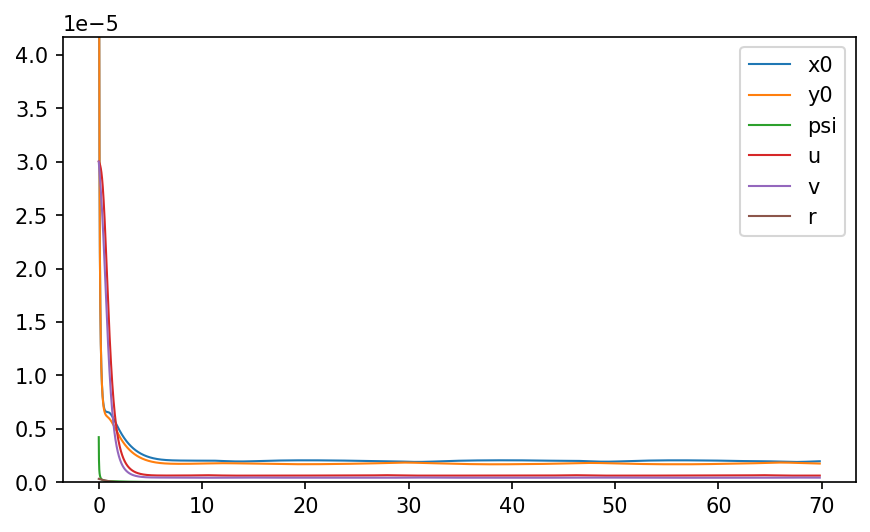

In [20]:
fig,ax=plt.subplots()
df_variance.plot(ax=ax)
ax.set_ylim(0,0.3*df_variance.max().max());